In [78]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import psycopg2

# 1. DataLoad

In [2]:
conn = psycopg2.connect("host=15.165.18.39 port=5432 user=linkshops password=$dpdlvmflf4 dbname=LINKSHOPS-20211121")

curs = conn.cursor()

In [3]:
#SQL = "SELECT * FROM ( SELECT ROW_NUMBER () OVER (ORDER BY 'id'), * FROM brands) x WHERE ROW_NUMBER BETWEEN 1 AND 30;"

In [4]:
SQL = "SELECT * FROM tb_credit_buyer_log"

In [5]:
curs.execute(SQL)

In [6]:
dataframe = pd.DataFrame(curs)

In [7]:
SQL = "SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE table_name = 'tb_credit_buyer_log'"

In [8]:
curs.execute(SQL)

In [9]:
dataframe.columns = [i[0] for i in curs]

In [10]:
dataframe

id                       created_at  creator_id use_yn  buyer_id  \
0        1 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
1        2 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
2        3 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
3        4 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
4        5 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
...    ...                              ...         ...    ...       ...   
6102  6103 2021-11-16 21:12:39.655984+00:00          44      Y     52048   
6103  6104 2021-11-17 08:42:28.406188+00:00         194      Y     52048   
6104  6105 2021-11-19 10:45:04.483768+00:00         193      Y     22020   
6105  6106 2021-11-19 10:56:25.597858+00:00         193      Y     22020   
6106  6107 2021-11-19 10:57:05.296935+00:00         193      Y     22020   

      brand_id     credit used_credit  status  \
0         8538    7000.00     7000.00     400   
1         7963   10000.00    10000.00     400   
2         9124   15000.00    15000.00     400   
3        12882    6000.00        0.00     200   
4         6499   69000.00    69000.00     400   
...        ...        ...         ...     ...   
6102     16241  136000.00    30000.00     300   
6103     16241  136000.00   136000.00     400   
6104     16638    2000.00        0.00     200   
6105     16638    2000.00        0.00     900   
6106     16638    2000.00        0.00     200   

                                     memo refund_vat deleted_memo  \
0       169652/#아띠랑스/마 3부 점프 슈트/네이비/누락 품절     700.00         None   
1             168425/#ELSI/단가라니트OPS /누락품절    1000.00         None   
2               159942/#더밍샵/모먼핏 원피스/교환환불건    1500.00         None   
3      매입일자:18-03-26 / 바이어명 : 백련 / 단추블라우스     600.00         None   
4     매입일자:18-02-20 / 바이어명 : 커먼페럴 / 호피퍼CT    6900.00         None   
...                                   ...        ...          ...   
6102                               매장확인완료   13600.00         None   
6103                               매장확인완료   13600.00         None   
6104                                  과입금     200.00         None   
6105                                  과입금     200.00        사유미기재   
6106                               과입금차액건     200.00         None   

     seller_approval_credit  credit_buyer_id  platform  creator_type  \
0                   7000.00              263       100           100   
1                  10000.00              264       100           100   
2                  15000.00              256       100           100   
3                      0.00              155       100           100   
4                  69000.00              198       100           100   
...                     ...              ...       ...           ...   
6102              136000.00             2935       101           200   
6103              136000.00             2935       100           100   
6104                2000.00             2937       100           100   
6105                2000.00             2937       100           100   
6106                2000.00             2938       100           100   

      log_type  buyer_type  
0          100         100  
1          100         100  
2          100         100  
3          100         100  
4          100         100  
...        ...         ...  
6102       200         200  
6103       300         200  
6104       100         200  
6105       500         200  
6106       100         200  

[6107 rows x 18 columns]

# 2. EDA

## 1) 데이터 현황 파악

### (1) 결측값 여부 확인

In [11]:
dataframe.apply(lambda x : x.isna().value_counts())

id  created_at  creator_id  use_yn  buyer_id  brand_id  credit  \
False  6107.0      6107.0      6107.0  6107.0    6107.0    6107.0  6107.0   
True      NaN         NaN         NaN     NaN       NaN       NaN     NaN   

       used_credit  status    memo  refund_vat  deleted_memo  \
False       6107.0  6107.0  6107.0        4269           205   
True           NaN     NaN     NaN        1838          5902   

       seller_approval_credit  credit_buyer_id  platform  creator_type  \
False                  6107.0           6107.0    6107.0        6107.0   
True                      NaN              NaN       NaN           NaN   

       log_type  buyer_type  
False    6107.0      6107.0  
True        NaN         NaN

- refund_vat과 deleted_memo에 결측값이 존재한다.

- deleted_memo는 유저가 옵션으로 입력하는 부분이라고 볼 수 있어 결측값이 있는것이 자연스럽다.

- 그러나, refund_vat이 결측값이 있는 것은 다소 부자연스러우므로 확인이 필요하다.

In [12]:
dataframe.describe()

id   creator_id       buyer_id      brand_id       status  \
count  6107.000000  6107.000000    6107.000000   6107.000000  6107.000000   
mean   3054.000000    84.975111   58656.405436   9408.353856   313.869330   
std    1763.083379    61.651717   27288.165181   3833.414363   130.993875   
min       1.000000     1.000000    5064.000000     29.000000   200.000000   
25%    1527.500000     1.000000   35811.000000   6378.500000   200.000000   
50%    3054.000000   120.000000   58834.000000   9470.000000   300.000000   
75%    4580.500000   129.000000   80296.000000  12187.000000   400.000000   
max    6107.000000   215.000000  143387.000000  18079.000000   900.000000   

       credit_buyer_id     platform  creator_type     log_type   buyer_type  
count      6107.000000  6107.000000   6107.000000  6107.000000  6107.000000  
mean       1857.600950   100.133945    113.394465   196.004585   192.336663  
std         786.333792     0.340621     34.062073   107.713113    26.603061  
min           1.000000   100.000000    100.000000   100.000000   100.000000  
25%        1397.500000   100.000000    100.000000   100.000000   200.000000  
50%        2000.000000   100.000000    100.000000   200.000000   200.000000  
75%        2492.000000   100.000000    100.000000   300.000000   200.000000  
max        2938.000000   101.000000    200.000000   500.000000   200.000000

In [13]:
dataframe.status.unique()

array([400, 200, 300, 900], dtype=int64)

In [14]:
dataframe.log_type.unique()

array([100, 200, 300, 400, 500], dtype=int64)

In [15]:
dataframe.platform.unique()

array([100, 101], dtype=int64)

<AxesSubplot:>

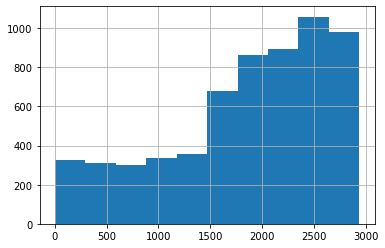

In [16]:
dataframe.credit_buyer_id.hist()

- status의 경우 200, 300, 400, 900의 명목형 변수이다.


- log_type의 경우 100,200,300,400,500의 명목형 변수이다.


- credit_buyer_id가 매입금 발행에 대하여 공평하게 발행된 사안이라면 히스토그램 각 빈도구간별로 빈도 차이가 나타날리가 없다. 확인이 필요하다. -> 매입금 청산 시 삭제되는지?

## 2) log_type, status 기반 분석

### (1) 각 변수별 현황

In [17]:
dataframe[(dataframe['brand_id'] == 17351) & (dataframe['log_type'] == 100)]

id                       created_at  creator_id use_yn  buyer_id  \
5987  5988 2021-09-15 05:07:14.301098+00:00         130      Y    143387   
5991  5992 2021-09-16 00:52:39.409336+00:00         130      Y    143387   
6069  6070 2021-10-29 04:44:59.307731+00:00         191      Y    143387   

      brand_id     credit used_credit  status         memo refund_vat  \
5987     17351   22000.00        0.00     200   링크#이전남은매입금    2200.00   
5991     17351  144800.00        0.00     200  링크#이전남은 매입금   14480.00   
6069     17351    9680.00        0.00     200      부가세과입금건     968.00   

     deleted_memo seller_approval_credit  credit_buyer_id  platform  \
5987         None               22000.00             2921       100   
5991         None              144800.00             2922       100   
6069         None                9680.00             2929       100   

      creator_type  log_type  buyer_type  
5987           100       100         200  
5991           100       100         200  
6069           100       100         200

브랜드ID 17351번의 경우, 

In [18]:
dataframe['log_type'].unique()

array([100, 200, 300, 400, 500], dtype=int64)

- 100 : 최초 생성
- 200 : 승인금액변경
- 300 : 매입차감
- 400 : 롤백
- 500 : 상태변경

In [19]:
dataframe['log_type'].value_counts()

100    2938
300    1715
200    1045
400     248
500     161
Name: log_type, dtype: int64

In [20]:
dataframe['status'].unique()

array([400, 200, 300, 900], dtype=int64)

- 200 : 차감승인
- 300 : 부분차감
- 400 : 차감완료

In [21]:
dataframe['status'].value_counts()

200    2459
400    2340
300    1147
900     161
Name: status, dtype: int64

#### - 양자간 교차분석

In [22]:
dataframe.groupby('log_type')['status'].value_counts()

log_type  status
100       200       1711
          400       1202
          300         25
200       200        594
          300        451
300       400       1138
          300        577
400       200        154
          300         94
500       900        161
Name: status, dtype: int64

- 대체적으로 최초 생성시(log_type = 100)엔 대부분 차감 승인(200)이나 차감 완료(400)도 같이 등장했다
- 승인금액변경(log_type = 200)엔 차감 승인(200)이나 부분 차감이(300) 항상 같이 등장했다. 단 차감완료(400)은 없었다.
- 매입차감(log_type = 300)엔 부분 차감(300)와 차감 완료(400)이항상 같이 등장했다.
- 롤백(log_type = 400)엔 차감 승인(200)이나 부분차감(300)이 같이 등장했다.
- 상태변경(log_type = 500)엔 기타(900)이 100% 등장했다.

#### - 파생변수 deriv_credit 생성

- 생성된 매입금을 뜻하는 credit과 사용(차감)된 매입금을 뜻하는 used_credit간 차이를 도출한다.

In [23]:
dataframe['deriv_credit'] = dataframe['credit'] - dataframe['used_credit']

#### - status vs log_type

In [25]:
result_log_type = dataframe.groupby(['buyer_id', 'brand_id', 'credit']).apply(lambda x : list(x['log_type'])).reset_index()

In [26]:
result_log_type.apply(lambda x : x[0][0], axis = 1).value_counts()

100    2712
200      23
300      11
500       2
dtype: int64

log_type의 경우, 첫 번째는 역시 '최초 생성(100)'으로 시작하는 경우가 많았다.

첫번째가 '승인금액변경', '매입차감', '상태변경'인 경우도 소수나마 존재하긴 한다.

In [96]:
dataframe

id                       created_at  creator_id use_yn  buyer_id  \
0        1 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
1        2 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
2        3 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
3        4 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
4        5 2019-05-14 11:38:38.135827+00:00           1      Y      8525   
...    ...                              ...         ...    ...       ...   
6102  6103 2021-11-16 21:12:39.655984+00:00          44      Y     52048   
6103  6104 2021-11-17 08:42:28.406188+00:00         194      Y     52048   
6104  6105 2021-11-19 10:45:04.483768+00:00         193      Y     22020   
6105  6106 2021-11-19 10:56:25.597858+00:00         193      Y     22020   
6106  6107 2021-11-19 10:57:05.296935+00:00         193      Y     22020   

      brand_id     credit used_credit  status  \
0         8538    7000.00     7000.00     400   
1         7963   10000.00    10000.00     400   
2         9124   15000.00    15000.00     400   
3        12882    6000.00        0.00     200   
4         6499   69000.00    69000.00     400   
...        ...        ...         ...     ...   
6102     16241  136000.00    30000.00     300   
6103     16241  136000.00   136000.00     400   
6104     16638    2000.00        0.00     200   
6105     16638    2000.00        0.00     900   
6106     16638    2000.00        0.00     200   

                                     memo refund_vat deleted_memo  \
0       169652/#아띠랑스/마 3부 점프 슈트/네이비/누락 품절     700.00         None   
1             168425/#ELSI/단가라니트OPS /누락품절    1000.00         None   
2               159942/#더밍샵/모먼핏 원피스/교환환불건    1500.00         None   
3      매입일자:18-03-26 / 바이어명 : 백련 / 단추블라우스     600.00         None   
4     매입일자:18-02-20 / 바이어명 : 커먼페럴 / 호피퍼CT    6900.00         None   
...                                   ...        ...          ...   
6102                               매장확인완료   13600.00         None   
6103                               매장확인완료   13600.00         None   
6104                                  과입금     200.00         None   
6105                                  과입금     200.00        사유미기재   
6106                               과입금차액건     200.00         None   

     seller_approval_credit  credit_buyer_id  platform  creator_type  \
0                   7000.00              263       100           100   
1                  10000.00              264       100           100   
2                  15000.00              256       100           100   
3                      0.00              155       100           100   
4                  69000.00              198       100           100   
...                     ...              ...       ...           ...   
6102              136000.00             2935       101           200   
6103              136000.00             2935       100           100   
6104                2000.00             2937       100           100   
6105                2000.00             2937       100           100   
6106                2000.00             2938       100           100   

      log_type  buyer_type deriv_credit  
0          100         100         0.00  
1          100         100         0.00  
2          100         100         0.00  
3          100         100      6000.00  
4          100         100         0.00  
...        ...         ...          ...  
6102       200         200    106000.00  
6103       300         200         0.00  
6104       100         200      2000.00  
6105       500         200      2000.00  
6106       100         200      2000.00  

[6107 rows x 19 columns]

In [27]:
result_status = dataframe.groupby(['buyer_id', 'brand_id', 'credit']).apply(lambda x : list(x['status'])).reset_index()

In [28]:
result_deriv_credit = dataframe.groupby(['buyer_id', 'brand_id', 'credit']).apply(lambda x : list(x['deriv_credit'])).reset_index()

In [29]:
result_status

buyer_id  brand_id     credit  \
0         5064      5063  107000.00   
1         5064      5111   32000.00   
2         5064      5553    1000.00   
3         5064      5615   16000.00   
4         5064      5664   10000.00   
...        ...       ...        ...   
2743    143387     17351   22000.00   
2744    143387     17351  144800.00   
2745    143387     17413   23000.00   
2746    143387     17413  115000.00   
2747    143387     17413  156000.00   

                                                      0  
0                                                 [200]  
1                                                 [400]  
2                                                 [400]  
3                                                 [400]  
4                                                 [400]  
...                                                 ...  
2743                                         [200, 400]  
2744  [200, 200, 200, 300, 300, 300, 300, 300, 300, ...  
2745                                         [200, 400]  
2746  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...  
2747                                    [200, 200, 300]  

[2748 rows x 4 columns]

In [30]:
result_deriv_credit

buyer_id  brand_id     credit  \
0         5064      5063  107000.00   
1         5064      5111   32000.00   
2         5064      5553    1000.00   
3         5064      5615   16000.00   
4         5064      5664   10000.00   
...        ...       ...        ...   
2743    143387     17351   22000.00   
2744    143387     17351  144800.00   
2745    143387     17413   23000.00   
2746    143387     17413  115000.00   
2747    143387     17413  156000.00   

                                                      0  
0                                           [107000.00]  
1                                                [0.00]  
2                                                [0.00]  
3                                                [0.00]  
4                                                [0.00]  
...                                                 ...  
2743                                   [22000.00, 0.00]  
2744  [144800.00, 144800.00, 144800.00, 56800.00, 56...  
2745                                   [23000.00, 0.00]  
2746  [96000.00, 79000.00, 79000.00, 65000.00, 65000...  
2747                  [156000.00, 156000.00, 137000.00]  

[2748 rows x 4 columns]

In [31]:
result_merged = pd.merge(
         pd.merge(
                  result_log_type, 
                  result_status, 
                  on = ['buyer_id', 'brand_id', 'credit']), 
         result_deriv_credit, 
         on = ['buyer_id','brand_id','credit'])

In [32]:
result_merged.columns = ['buyer_id','brand_id','credit', 'log_type','status','deriv_credit']

In [33]:
def string_concater(x1, x2):
    new_list = list()
    for y1, y2 in zip(x1, x2):
        new_list.append(str(y1) + '-' + str(y2))
    return new_list

#### - 각 브랜드ID / 바이어ID / 매입액 별 첫번째 log_type과 status

In [110]:
result_merged['log_type_status'].apply(lambda x : x[0]).value_counts()

100-200    1576
100-400    1111
100-300      25
200-200      15
200-300       8
300-400       7
300-300       4
500-900       2
Name: log_type_status, dtype: int64

- 100 - 200과 100 - 400은 신규 생성 - 차감승인/차감완료 사례라 타당한 것으로 보인다.

- 문제는 그 외의 사례들이다.

- 나머지 사례들이 어떤 경우인지 확인이 필요하다.

In [119]:
dataframe[dataframe['brand_id'] == 10687]

id                       created_at  creator_id use_yn  buyer_id  \
1098  1099 2019-05-14 11:38:38.135827+00:00           1      Y     35037   
4485  4250 2020-01-08 06:43:55.267030+00:00         115      Y     60330   
4488  4253 2020-01-08 07:16:41.058832+00:00         148      Y     60330   
5864  5865 2021-09-02 07:21:46.145006+00:00         189      Y    143387   
5868  5869 2021-09-02 07:41:31.852645+00:00         130      Y    143387   
5881  5882 2021-09-02 21:36:15.684248+00:00          44      Y    143387   
5885  5886 2021-09-03 06:34:57.205224+00:00         148      Y    143387   
5916  5917 2021-09-07 21:01:51.921308+00:00          44      Y    143387   
5922  5923 2021-09-08 07:45:57.757441+00:00         130      Y    143387   
5929  5930 2021-09-08 08:26:50.993097+00:00         148      Y    143387   
5930  5931 2021-09-08 08:26:50.993097+00:00         148      Y    143387   
5937  5938 2021-09-08 20:43:28.191891+00:00          44      Y    143387   
5940  5941 2021-09-08 20:57:52.740643+00:00          44      Y    143387   
5945  5946 2021-09-09 07:45:37.532133+00:00         148      Y    143387   
5951  5952 2021-09-09 21:08:43.440753+00:00          44      Y    143387   
5954  5955 2021-09-09 21:51:07.628826+00:00          44      Y    143387   
5955  5956 2021-09-10 05:09:06.452111+00:00         148      Y    143387   

      brand_id    credit used_credit  status  \
1098     10687  21000.00    21000.00     400   
4485     10687  11000.00        0.00     200   
4488     10687  11000.00    11000.00     400   
5864     10687  52200.00        0.00     200   
5868     10687  52200.00        0.00     200   
5881     10687  52200.00        0.00     200   
5885     10687  52200.00     7000.00     300   
5916     10687  45200.00     7000.00     300   
5922     10687  45200.00    16600.00     300   
5929     10687  45200.00     7000.00     300   
5930     10687  45200.00    16600.00     300   
5937     10687  45200.00    16600.00     300   
5940     10687  45200.00    16600.00     300   
5945     10687  45200.00    41500.00     300   
5951     10687  45200.00    41500.00     300   
5954     10687  45200.00    41500.00     300   
5955     10687  45200.00    45200.00     400   

                                                   memo refund_vat  \
1098                                           1/14 장끼건    2100.00   
4485  E-8800 히든슬렉스(8800 히든 밴딩 슬랙스) / [라이트그레이-2XL(36)...    1100.00   
4488  E-8800 히든슬렉스(8800 히든 밴딩 슬랙스) / [라이트그레이-2XL(36)...    1100.00   
5864                                              남은매입금    5220.00   
5868                                              남은매입금    5220.00   
5881                                              남은매입금    5220.00   
5885                                              남은매입금    5220.00   
5916                                              남은매입금    4520.00   
5922                                              남은매입금    4520.00   
5929                                              남은매입금    4520.00   
5930                                              남은매입금    4520.00   
5937                                              남은매입금    4520.00   
5940                                              남은매입금    4520.00   
5945                                              남은매입금    4520.00   
5951                                              남은매입금    4520.00   
5954                                              남은매입금    4520.00   
5955                                              남은매입금    4520.00   

     deleted_memo seller_approval_credit  credit_buyer_id  platform  \
1098         None               21000.00             1062       100   
4485         None               11000.00             2437       100   
4488         None               11000.00             2437       100   
5864         None               52200.00             2899       100   
5868         None                   0.00             2899       100   
5881         None                7000.00             2899       101   
5885         Non

In [118]:
result_merged[result_merged['brand_id'] == 	10687]

buyer_id  brand_id    credit  \
725      35037     10687  21000.00   
1571     60330     10687  11000.00   
2711    143387     10687  45200.00   
2712    143387     10687  52200.00   

                                               log_type  \
725                                               [100]   
1571                                         [100, 300]   
2711  [200, 300, 400, 300, 200, 200, 300, 200, 200, ...   
2712                               [100, 200, 200, 300]   

                                                 status  \
725                                               [400]   
1571                                         [200, 400]   
2711  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
2712                               [200, 200, 200, 300]   

                                           deriv_credit  \
725                                              [0.00]   
1571                                   [11000.00, 0.00]   
2711  [38200.00, 28600.00, 38200.00, 28600.00, 28600...   
2712           [52200.00, 52200.00, 52200.00, 45200.00]   

                                        log_type_status  \
725                                           [100-400]   
1571                                 [100-200, 300-400]   
2711  [200-300, 300-300, 400-300, 300-300, 200-300, ...   
2712               [100-200, 200-200, 200-200, 300-300]   

                                      diff_deriv_credit  \
725                                                  []   
1571                                        [-11000.00]   
2711  [-9600.00, 9600.00, -9600.00, 0.00, 0.00, -249...   
2712                             [0.00, 0.00, -7000.00]   

                                  diff_deriv_credit_neg  
725                                                  []  
1571                                             [True]  
2711  [True, False, True, False, False, True, False,...  
2712                               [False, False, True]

In [117]:
result_merged[result_merged['log_type_status'].apply(lambda x : x[0] not in ['100-200', '100-400'])]

buyer_id  brand_id     credit  \
11        6796      9124  200000.00   
48        8525      4531   34000.00   
81        8525      6619   38000.00   
91        8525      7739   37400.00   
113       8525      8444   25000.00   
...        ...       ...        ...   
2622     88487     11067   72000.00   
2665     88487     15821    4500.00   
2705    143387      5692   52000.00   
2711    143387     10687   45200.00   
2746    143387     17413  115000.00   

                                               log_type  \
11    [300, 300, 300, 200, 300, 200, 300, 300, 300, ...   
48                                                [100]   
81                                                [100]   
91                                                [100]   
113                                               [100]   
...                                                 ...   
2622                     [200, 300, 100, 300, 200, 300]   
2665                                         [300, 100]   
2705                               [200, 300, 200, 300]   
2711  [200, 300, 400, 300, 200, 200, 300, 200, 200, ...   
2746  [200, 300, 200, 300, 200, 300, 400, 300, 200, ...   

                                                 status  \
11    [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
48                                                [300]   
81                                                [300]   
91                                                [300]   
113                                               [300]   
...                                                 ...   
2622                     [300, 400, 200, 300, 300, 300]   
2665                                         [400, 200]   
2705                               [300, 300, 300, 400]   
2711  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
2746  [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   

                                           deriv_credit  \
11    [159000.00, 133000.00, 103000.00, 106000.00, 7...   
48                                           [12000.00]   
81                                            [9000.00]   
91                                            [9400.00]   
113                                           [6000.00]   
...                                                 ...   
2622  [11000.00, 0.00, 72000.00, 42000.00, 42000.00,...   
2665                                    [0.00, 4500.00]   
2705               [40000.00, 20000.00, 20000.00, 0.00]   
2711  [38200.00, 28600.00, 38200.00, 28600.00, 28600...   
2746  [96000.00, 79000.00, 79000.00, 65000.00, 65000...   

                                        log_type_status  \
11    [300-300, 300-300, 300-300, 200-300, 300-300, ...   
48                                            [100-300]   
81                                            [100-300]   
91                                            [100-300]   
113                                           [100-300]   
...                                                 ...   
2622  [200-300, 300-400, 100-200, 300-300, 200-300, ...   
2665                                 [300-400, 100-200]   
2705               [200-300, 300-300, 200-300, 300-400]   
2711  [200-300, 300-300, 400-300, 300-300, 200-300, ...   
2746  [200-300, 300-300, 200-300, 300-300, 200-300, ...   

                                      diff_deriv_credit  \
11    [-26000.00, -30000.00, 3000.00, -28000.00, 0.0...   
48                                                   []   
81                                                   []   
91                                                   []   
113                                                  []   
...                                                 ...   
2622  [-11000.00, 72000.00, -30000.00, 0.00, -31000.00]   
2665                                          [4500.00]   
2705                       [-20000.00, 0.00, -20000.00]   
2711  [-9600.00, 9600.00, -9600.00, 0.00, 0.00, -249...   
2746  [-17000.00, 0.00, -14000.00, 0.00, -23000.00, 

#### - 실제 금액 차감이 이루어졌을 때 log_type과 status

In [100]:
result_merged['log_type_status'] = result_merged.apply(lambda x : string_concater(x['log_type'],x['status']), axis = 1)

In [101]:
result_merged['diff_deriv_credit'] = result_merged.apply(lambda x : np.diff(x['deriv_credit']), axis = 1)

In [102]:
result_merged['diff_deriv_credit_neg'] = result_merged[result_merged['log_type_status'].apply(
    lambda x : len(x)) > 0]['diff_deriv_credit'].apply(lambda x : np.array(x) < 0)

In [103]:
log_type_status = result_merged[result_merged['log_type_status'].apply(lambda x : len(x)) > 0].apply(
    lambda x : np.unique(np.array(x['log_type_status'][1:])[x['diff_deriv_credit_neg']]), axis = 1)

잔액 매입금 차감이 이루어졌을 때의 log_type과 status의 빈도표는 아래와 같다.

In [104]:
log_type_status.apply(lambda x : pd.Series(x).value_counts()).sum()

100-400     22.0
200-300      6.0
300-300    262.0
300-400    930.0
dtype: float64

300-300과 300-400은 매입 차감 - 부분차감/차감완료 부분이라 이해가 가능하다.

그런데, 200-300과 100-400은 승인금액변경 - 부분차감과 최초생성 - 차감완료라 확인이 필요하다.

In [39]:
result_merged[result_merged['log_type_status'].apply(lambda x : len(x)) > 0][log_type_status.apply(lambda x : '100-400' in x)]

buyer_id  brand_id     credit              log_type  \
83        8525      6745   30000.00            [100, 100]   
407      34500     10187   10000.00            [100, 100]   
569      34559     11710  100000.00            [100, 100]   
720      35037     10353    1000.00            [100, 100]   
909      39779      5519     500.00            [100, 100]   
1030     39779     10962    1000.00            [100, 100]   
1047     39779     11615    1000.00  [100, 100, 100, 100]   
1113     45065      7209   45000.00            [100, 100]   
1167     46505      2094   12000.00            [100, 100]   
1219     46505      7806   22000.00            [100, 100]   
1263     46505     10901    2000.00            [100, 100]   
1403     48526     11486   39000.00            [100, 100]   
1453     52048     11643   89000.00            [100, 100]   
1690     61663      8634   65000.00       [100, 100, 100]   
1711     61663     12569   60000.00            [100, 100]   
1770     61910      5345   48000.00            [100, 100]   
1773     61910      5568    2000.00            [100, 100]   
1774     61910      5568   23000.00            [100, 100]   
1815     63480      5139   52000.00            [100, 100]   
1816     63480      5557   18000.00            [100, 100]   
1839     64730     10586   19000.00       [100, 100, 100]   
2210     72218     13505   35000.00            [100, 100]   

                    status                 deriv_credit  \
83              [200, 400]             [30000.00, 0.00]   
407             [200, 400]             [10000.00, 0.00]   
569             [200, 400]            [100000.00, 0.00]   
720             [200, 400]              [1000.00, 0.00]   
909             [200, 400]               [500.00, 0.00]   
1030            [200, 400]              [1000.00, 0.00]   
1047  [400, 200, 400, 400]  [0.00, 1000.00, 0.00, 0.00]   
1113            [200, 400]             [45000.00, 0.00]   
1167            [200, 400]             [12000.00, 0.00]   
1219            [200, 400]             [22000.00, 0.00]   
1263            [200, 400]              [2000.00, 0.00]   
1403            [200, 400]             [39000.00, 0.00]   
1453            [200, 400]             [89000.00, 0.00]   
1690       [200, 200, 400]   [65000.00, 65000.00, 0.00]   
1711            [200, 400]             [60000.00, 0.00]   
1770            [200, 400]             [48000.00, 0.00]   
1773            [200, 400]              [2000.00, 0.00]   
1774            [200, 400]             [23000.00, 0.00]   
1815            [200, 400]             [52000.00, 0.00]   
1816            [200, 400]             [18000.00, 0.00]   
1839       [400, 200, 400]       [0.00, 19000.00, 0.00]   
2210            [200, 400]             [35000.00, 0.00]   

                  log_type_status          diff_deriv_credit  \
83                      [100-400]                [-30000.00]   
407                     [100-400]                [-10000.00]   
569                     [100-400]               [-100000.00]   
720                     [100-400]                 [-1000.00]   
909                     [100-400]                  [-500.00]   
1030                    [100-400]                 [-1000.00]   
1047  [100-200, 100-400, 100-400]  [1000.00, -1000.00, 0.00]   
1113                    [100-400]                [-45000.00]   
1167                    [100-400]                [-12000.00]   
1219                    [100-400]                [-22000.00]   
1263                    [100-400]                 [-2000.00]   
1403                    [100-400]                [-39000.00]   
1453                    [100-400]                [-89000.00]   
1690           [100-200, 100-400]          [0.00, -65000.00]   
1711                    [100-400]                [-60000.00]   
1770                    [100-400]                [-48000.00]   
1773                    [100-400]                 [-2000.00]   
1774                    [100-400]                [-23000.00]   
1815                    [100

In [40]:
result_merged[result_merged['log_type_status'].apply(lambda x : len(x)) > 0][log_type_status.apply(lambda x : '200-300' in x)]

buyer_id  brand_id     credit  \
11        6796      9124  200000.00   
336      33285      3377  198000.00   
1806     62561      7796   54000.00   
2594     88487      7709  118000.00   
2635     88487     12062   26000.00   
2655     88487     14286   64000.00   

                                               log_type  \
11    [300, 300, 300, 200, 300, 200, 300, 300, 300, ...   
336                           [200, 300, 100, 200, 300]   
1806  [100, 200, 200, 300, 200, 300, 200, 300, 400, ...   
2594                                    [100, 200, 300]   
2635                                    [100, 200, 300]   
2655                                    [100, 200, 300]   

                                                 status  \
11    [300, 300, 300, 300, 300, 300, 300, 300, 300, ...   
336                           [200, 300, 200, 300, 400]   
1806  [200, 300, 300, 400, 200, 300, 300, 300, 300, ...   
2594                                    [200, 300, 400]   
2635                                    [200, 300, 400]   
2655                                    [200, 300, 400]   

                                           deriv_credit  \
11    [159000.00, 133000.00, 103000.00, 106000.00, 7...   
336    [198000.00, 16000.00, 198000.00, 16000.00, 0.00]   
1806  [54000.00, 16000.00, 16000.00, 0.00, 54000.00,...   
2594                        [118000.00, 35000.00, 0.00]   
2635                         [26000.00, 14000.00, 0.00]   
2655                         [64000.00, 48000.00, 0.00]   

                                        log_type_status  \
11    [300-300, 300-300, 200-300, 300-300, 200-300, ...   
336                [300-300, 100-200, 200-300, 300-400]   
1806  [200-300, 200-300, 300-400, 200-200, 300-300, ...   
2594                                 [200-300, 300-400]   
2635                                 [200-300, 300-400]   
2655                                 [200-300, 300-400]   

                                      diff_deriv_credit  \
11    [-26000.00, -30000.00, 3000.00, -28000.00, 0.0...   
336      [-182000.00, 182000.00, -182000.00, -16000.00]   
1806  [-38000.00, 0.00, -16000.00, 54000.00, -7000.0...   
2594                             [-83000.00, -35000.00]   
2635                             [-12000.00, -14000.00]   
2655                             [-16000.00, -48000.00]   

                                  diff_deriv_credit_neg  
11    [True, True, False, True, False, True, True, F...  
336                           [True, False, True, True]  
1806  [True, False, True, False, True, False, True, ...  
2594                                       [True, True]  
2635                                       [True, True]  
2655                                       [True, True]

In [95]:
result_merged[result_merged['brand_id'] == 7796]['deriv_credit'].tolist()

[[Decimal('54000.00'),
  Decimal('16000.00'),
  Decimal('16000.00'),
  Decimal('0.00'),
  Decimal('54000.00'),
  Decimal('47000.00'),
  Decimal('47000.00'),
  Decimal('21000.00'),
  Decimal('47000.00'),
  Decimal('21000.00'),
  Decimal('47000.00'),
  Decimal('21000.00'),
  Decimal('21000.00'),
  Decimal('16000.00'),
  Decimal('21000.00'),
  Decimal('16000.00')]]

In [98]:
DataFrame({'1' : result_merged[result_merged['brand_id'] == 7796]['log_type_status'].tolist()[0],
           '2' : result_merged[result_merged['brand_id'] == 7796]['diff_deriv_credit'].tolist()[0],
           '3' : result_merged[result_merged['brand_id'] == 7796]['deriv_credit'].tolist()[0][1:]})

1          2         3
0   200-300  -38000.00  16000.00
1   200-300       0.00  16000.00
2   300-400  -16000.00      0.00
3   200-200   54000.00  54000.00
4   300-300   -7000.00  47000.00
5   200-300       0.00  47000.00
6   300-300  -26000.00  21000.00
7   400-300   26000.00  47000.00
8   300-300  -26000.00  21000.00
9   400-300   26000.00  47000.00
10  300-300  -26000.00  21000.00
11  200-300       0.00  21000.00
12  300-300   -5000.00  16000.00
13  400-300    5000.00  21000.00
14  300-300   -5000.00  16000.00